# PyCP_APR

In [1]:
import pandas as pd
import numpy as np
import gzip
import matplotlib.pyplot as plt
import datetime 
from pyCP_APR import CP_APR
from pyCP_APR.datasets import load_dataset
from sklearn.model_selection import train_test_split
from scipy import sparse

In [2]:
authentication_data = pd.read_csv('https://github.com/Galeforse/Advanced-Cyber-Analytics-for-Attack-Detection/raw/main/Data/Authentication%20data.gz', compression='gzip', index_col = 0)


/Users/lukehawley/opt/anaconda3/envs/pyCP_APR/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [31]:
authentication_data

,UserName,SrcDevice,DstDevice,Authent Type,Failure,DailyCount
0,User035855,Comp808475,Comp081330,TGS,0,17.0
1,Comp655251$,Comp655251,ActiveDirectory,NetworkLogon,0,350.0
2,User762066,Comp306129,ActiveDirectory,TGS,0,22.0
3,User384215,Comp095190,EnterpriseAppServer,NetworkLogon,0,35.0
4,User043263,Comp883307,Comp384394,TGS,0,2.0
...,...,...,...,...,...,...
80187,Comp955366$,Comp955366,ActiveDirectory,TGS,0,23.0
80188,Comp589380$,Comp589380,ActiveDirectory,TGT,0,37.0
80189,Comp629793$,Comp629793,ActiveDirectory,TGS,0,21.0
80190,User104387,Comp917362,ActiveDirectory,NetworkLogon,0,387.0


In [3]:
# splits a dataframe into n chunks
def split_dataframe(df,n): 
    chunks = list()
    chunk_size = int(np.round(df.shape[0]/n))
    num_chunks = n
    for i in range(num_chunks):
        if i != num_chunks-1:
            chunks.append(df[i*chunk_size:(i+1)*chunk_size])
        else:
            chunks.append(df[i*chunk_size:])
    return chunks

In [4]:
auth_index_list = authentication_data.index.tolist()
auth_start_days = [i for i, e in enumerate(auth_index_list) if e == 0]
auth_start_days.append(len(authentication_data))

def auth_type_un_df(user,n):
    auth_type_df = pd.DataFrame(index = list(authentication_data['Authent Type'].unique()))
    n = n

    for i in range(len(auth_start_days)-1):
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                data = chunks[j]
                auth_type_data = data[data['UserName'] == user].groupby('Authent Type').size()
                auth_type_df[i*n + j] = auth_type_df.index.to_series().map(auth_type_data.to_dict())

    auth_type_df = auth_type_df.transpose()
    auth_type_df = auth_type_df.fillna(0)
    
    return auth_type_df

In [5]:
auth_type_un_df('Comp655251$', 24)

,TGS,NetworkLogon,TGT,WorkstationLock,WorkstationUnlock,ScreensaverInvoked,InteractiveLogon,ScreensaverDismissed,Service,Batch,CachedInteractive,RemoteInteractive,CachedRemoteInteractive
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
def auth_type_un_sparse(user,n):
    auth_type_df = pd.DataFrame(index = list(authentication_data['Authent Type'].unique()))
    n = n

    for i in range(len(auth_start_days)-1):
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                data = chunks[j]
                auth_type_data = data[data['UserName'] == user].groupby('Authent Type').size()
                auth_type_df[i*n + j] = auth_type_df.index.to_series().map(auth_type_data.to_dict())

    auth_type_df = auth_type_df.transpose()
    auth_type_df = auth_type_df.fillna(0)
    
    s = sparse.coo_matrix(auth_type_df)
    
    co = []
    vals = s.data
    for i in range(len(s.row)):
        co.append([s.row[i],s.col[i]])
    
    return vals, co

vals, co = auth_type_un_sparse('User035855',24)

In [7]:
cp_apr = CP_APR(n_iters=10, random_state=42, verbose=200, 
                method='numpy', 
                return_type='numpy', 
               )

In [8]:
factors = cp_apr.fit(coords=np.array(co), values=vals, rank=2)
factors

CP-APR (MU):
Iter=1, Inner Iter=20, KKT Violation=0.355692, obj=-1776.397634, nViolations=0
Exiting because all subproblems reached KKT tol.
 Final log-likelihood = -1678.957187
 Final least squares fit = 0.362678
 Final KKT violation = 0.000084
 Total inner iterations = 91
 Total execution time = 0.0409 seconds
Converting the latent factors to Numpy arrays.


{'Factors': {'0': array([[2.21975593e-03, 2.68966355e-37],
         [1.10987797e-03, 0.00000000e+00],
         [2.21975593e-03, 6.37960887e-37],
         ...,
         [1.10987797e-03, 8.05316023e-28],
         [2.21975593e-03, 1.13853699e-26],
         [1.10987797e-03, 4.66871664e-28]]),
  '1': array([[5.77136476e-01, 4.37961659e-07],
         [3.41842429e-01, 6.10680142e-39],
         [2.46493800e-36, 3.71727586e-01],
         [3.55784256e-37, 2.87957989e-01],
         [8.10210952e-02, 4.15734180e-58],
         [0.00000000e+00, 0.00000000e+00],
         [9.87314823e-88, 3.29842787e-01],
         [0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00],
         [2.97929228e-21, 1.04711996e-02]])},
 'Weights': array([900.99995617, 191.00004383])}

In [9]:
vals_2, co_2 = auth_type_un_sparse('User762066',24)

In [10]:
y_score = cp_apr.predict_scores(coords=np.array(co_2), values=vals_2)
y_score

array([0.68471332, 0.49524638, 0.68471332, ..., 0.        , 0.        ,
       0.        ])

In [11]:
np.mean(y_score)


0.1277710632114597

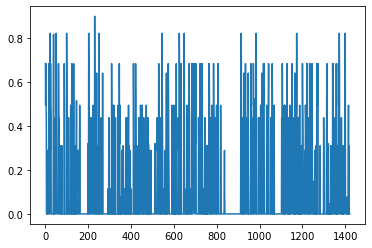

In [29]:
plt.plot(y_score)
plt.show()

# SrcDevice and DstDevice Version

In [41]:
# Trying to make Src/Dst Comp version

auth_index_list = authentication_data.index.tolist()
auth_start_days = [i for i, e in enumerate(auth_index_list) if e == 0]
auth_start_days.append(len(authentication_data))

def comp_type_un_df(user,n):
    comp_type_df = pd.DataFrame(index = list(authentication_data['DstDevice'].unique()))
    n = n

    for i in range(len(auth_start_days)-1):
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                data = chunks[j]
                comp_type_data = data[data['SrcDevice'] == user].groupby('DstDevice').size()
                comp_type_df[i*n + j] = comp_type_df.index.to_series().map(comp_type_data.to_dict())

    comp_type_df = comp_type_df.transpose()
    comp_type_df = comp_type_df.fillna(0)
    
    return comp_type_df

In [42]:
comp_type_un_df('Comp655251', 24)

,Comp081330,ActiveDirectory,EnterpriseAppServer,Comp384394,Comp915658,Comp658422,Comp916004,Comp521945,Comp039634,None,...,Comp831671,Comp091716,Comp534157,Comp149616,Comp583359,Comp232021,Comp753234,Comp289372,Comp637530,Comp644596
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2158,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
def comp_type_un_sparse(user,n,e):
    comp_type_df = pd.DataFrame(index = list(authentication_data['DstDevice'].unique()))
    n = n

    for i in range(len(auth_start_days)-1):
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                data = chunks[j]
                comp_type_data = data[data['SrcDevice'] == user].groupby('DstDevice').size()
                comp_type_df[i*n + j] = comp_type_df.index.to_series().map(comp_type_data.to_dict())

    comp_type_df = comp_type_df.transpose()
    comp_type_df = comp_type_df.fillna(0)
    
    s = sparse.coo_matrix(comp_type_df)
    
    co_comp = []
    vals_comp = s.data
    for i in range(len(s.row)):
        co_comp.append([s.row[i],s.col[i], e])
    
    return vals_comp, co_comp

vals_comp, co_comp = comp_type_un_sparse('Comp655251',24,0)

In [54]:
cp_apr_comp = CP_APR(n_iters=10, random_state=42, verbose=200, method='numpy', return_type='numpy')

In [55]:
factors_comp = cp_apr_comp.fit(coords=np.array(co_comp), values=vals_comp, rank=2)
factors_comp

CP-APR (MU):
Iter=1, Inner Iter=20, KKT Violation=0.336235, obj=-4079.623946, nViolations=0
 Final log-likelihood = -3951.466123
 Final least squares fit = 0.217334
 Final KKT violation = 0.071637
 Total inner iterations = 135
 Total execution time = 0.0695 seconds
Converting the latent factors to Numpy arrays.


{'Factors': {'0': array([[1.90005573e-03, 0.00000000e+00],
         [9.50027863e-04, 0.00000000e+00],
         [1.90005573e-03, 8.19291399e-33],
         ...,
         [0.00000000e+00, 0.00000000e+00],
         [1.90005245e-03, 4.49267989e-09],
         [2.85008359e-03, 4.00436740e-23]]),
  '1': array([[0.00000000e+00, 0.00000000e+00],
         [4.95921026e-01, 2.74026099e-17],
         [0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00],
         [3.77583129e-19, 2.60276683e-03]])},
 'Weights': array([1052.58694978,  768.41305022])}

In [56]:
vals_comp_2, co_comp_2 =comp_type_un_sparse('Comp004340', 24, 0)

In [63]:
s_time = datetime.datetime.now()

train_coords, train_vals = [], []
test_coords, test_vals = [], []

Src_Comps = list(authentication_data['SrcDevice'].unique())

for e, un in enumerate(Src_Comps):
    if e <= 19:
        vals, co = comp_type_un_sparse(un,24,e)
        train_coords.append(co)
        train_vals.append(vals)
    elif e <= 21:
        vals, co = comp_type_un_sparse(un,24,e-20)
        test_coords.append(co)
        test_vals.append(vals)

        
train_coords = np.array([item for sublist in train_coords for item in sublist])
test_coords = np.array([item for sublist in test_coords for item in sublist])

train_vals = np.array([item for sublist in train_vals for item in sublist])
test_vals = np.array([item for sublist in test_vals for item in sublist])

e_time = datetime.datetime.now()

print(e_time-s_time)

0:10:26.810102


In [64]:
cp_apr_comp_v2 = CP_APR(n_iters=10, random_state=42, verbose=200, method='numpy', return_type='numpy')

In [65]:
factors_comp_v2 = cp_apr_comp_v2.fit(coords=np.array(train_coords), values=train_vals, rank=2)
factors_comp_v2

CP-APR (MU):
Iter=1, Inner Iter=30, KKT Violation=0.803366, obj=1641554.314179, nViolations=0
 Final log-likelihood = 1675224.866518
 Final least squares fit = 0.921077
 Final KKT violation = 0.001089
 Total inner iterations = 215
 Total execution time = 0.5604 seconds
Converting the latent factors to Numpy arrays.


{'Factors': {'0': array([[0.0004708 , 0.00114601],
         [0.00038554, 0.00059269],
         [0.00049829, 0.00071843],
         ...,
         [0.00031299, 0.00031378],
         [0.00034032, 0.00013313],
         [0.00031092, 0.00034864]]),
  '1': array([[8.54834066e-74, 1.76434365e-02],
         [4.70986256e-01, 3.04941855e-01],
         [6.43437147e-61, 4.67237251e-03],
         ...,
         [0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00],
         [2.07354969e-06, 3.48671864e-04]]),
  '2': array([[3.85132968e-29, 6.26910952e-02],
         [5.52866296e-28, 6.34930391e-02],
         [1.13263307e-47, 5.56130683e-02],
         [5.78114497e-06, 4.86818653e-02],
         [9.61623009e-19, 5.68682849e-02],
         [1.86148198e-04, 5.55849971e-02],
         [3.97578139e-42, 1.18199562e-02],
         [9.99540479e-01, 3.88284831e-22],
         [7.11033950e-24, 4.20497557e-02],
         [2.70452805e-36, 4.69311536e-02],
         [1.36008498e-44, 3.36119109e-02],
 

In [66]:
y_score_v2 = cp_apr.predict_scores(coords=np.array(test_coords), values=test_vals)
y_score_v2

IndexError: index 2135 is out of bounds for axis 0 with size 2135

In [67]:
import scipy.stats as stats
import pylab

In [68]:
y_score_v2_1 = cp_apr.predict_scores(coords=np.array(co_comp_2), values=vals_comp_2)
np.where(y_score_v2_1<0.05)

plt.plot(y_score_v2_1)
plt.show()

plt.hist(y_score_v2_1)
plt.show()

stats.probplot(y_score_v2_1, plot=pylab)
pylab.show()

IndexError: index 2135 is out of bounds for axis 0 with size 2135

# LOF and other AD

In [12]:
authentication_data

,UserName,SrcDevice,DstDevice,Authent Type,Failure,DailyCount
0,User035855,Comp808475,Comp081330,TGS,0,17.0
1,Comp655251$,Comp655251,ActiveDirectory,NetworkLogon,0,350.0
2,User762066,Comp306129,ActiveDirectory,TGS,0,22.0
3,User384215,Comp095190,EnterpriseAppServer,NetworkLogon,0,35.0
4,User043263,Comp883307,Comp384394,TGS,0,2.0
...,...,...,...,...,...,...
80187,Comp955366$,Comp955366,ActiveDirectory,TGS,0,23.0
80188,Comp589380$,Comp589380,ActiveDirectory,TGT,0,37.0
80189,Comp629793$,Comp629793,ActiveDirectory,TGS,0,21.0
80190,User104387,Comp917362,ActiveDirectory,NetworkLogon,0,387.0


In [13]:
def auth_type_df(comp,n):
    auth_type_df = pd.DataFrame(index = list(authentication_data['Authent Type'].unique()))
    n = n

    for i in range(len(auth_start_days)-1):
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                data = chunks[j]
                auth_type_data = data[data['SrcDevice'] == comp].groupby('Authent Type').size()
                auth_type_df[i*n + j] = auth_type_df.index.to_series().map(auth_type_data.to_dict())

    auth_type_df = auth_type_df.transpose()
    auth_type_df = auth_type_df.fillna(0)
    
    return auth_type_df

In [14]:
Comp655251 = auth_type_df('Comp655251', 12)

In [69]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [22]:
Comp655251_scaler = StandardScaler()
Comp655251_scaler.fit(Comp655251)
Comp655251_scaled = Comp655251_scaler.transform(Comp655251)
Comp655251_data = pd.DataFrame(Comp655251_scaled)

In [70]:
lof = LocalOutlierFactor(n_neighbors=2)
lof_predictions = lof.fit_predict(Comp655251_data)

Comp655251_pca = PCA(n_components=2)
Comp655251_pca_data = pd.DataFrame(Comp655251_pca.fit_transform(Comp655251_data))

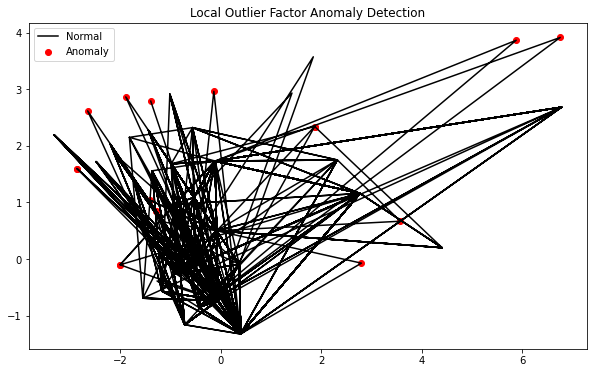

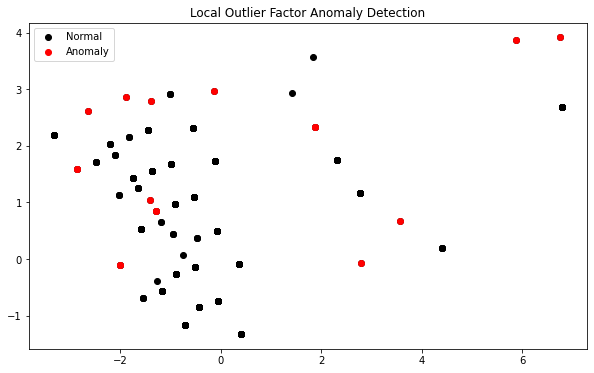

In [74]:
fig, ax = plt.subplots(figsize=(10,6))
a = Comp655251_pca_data.loc[lof_predictions == -1]
ax.plot(Comp655251_pca_data[0], Comp655251_pca_data[1], color='black', label='Normal')
ax.scatter(a[0], a[1], color='red', label='Anomaly')
ax.set_title("Local Outlier Factor Anomaly Detection")
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
a = Comp655251_pca_data.loc[lof_predictions == -1]
ax.scatter(Comp655251_pca_data[0], Comp655251_pca_data[1], color='black', label='Normal')
ax.scatter(a[0], a[1], color='red', label='Anomaly')
ax.set_title("Local Outlier Factor Anomaly Detection")
plt.legend()
plt.show()

In [19]:
from pyod.models.cof import COF